In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

In [273]:
# Load the data
df = pd.read_csv('data_co2.csv', names=['Year', 'PPM'], skiprows=1)

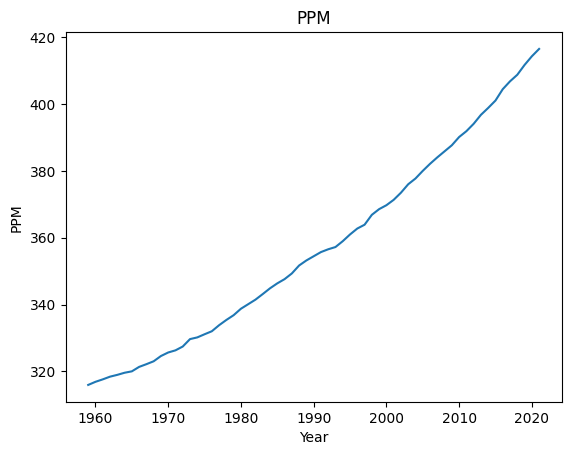

In [274]:
plt.plot(df['Year'], df['PPM'])
plt.xlabel('Year')
plt.ylabel('PPM')
plt.title('PPM')
plt.show()

In [275]:
df.drop('Year', axis=1, inplace=True)
data = df.values


def normalize(data, min, max):
    data = data - min
    data = data / (max - min)
    return data


def unnormalize(data, min, max):
    data = data * (max - min)
    data = data + min
    return data


data_normed = normalize(data, data.min(axis=0), data.max(axis=0))
data_normed[:10]

array([[0.        ],
       [0.00925649],
       [0.01652234],
       [0.02458445],
       [0.02995919],
       [0.03622972],
       [0.04041007],
       [0.05364786],
       [0.06170996],
       [0.07036926]])

In [276]:
split = int(0.8 * len(data_normed))
train, val = data_normed[:split], data_normed[split:]


def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    '''
    :param series: an iterable
    :param batch_size: number of samples per batch
    :param n_past: number of timesteps to look back (x or input to the model)
    :param n_future: number of timesteps to predict (y or output of the model)
    :param shift: number of timesteps to shift the window by, usually 1 if we want to maximise the use of data
    :return:
    '''
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_future], w[n_future:]))  # taking the past as x, future as y, split by n_past
    ds.shuffle(8192)
    return ds.batch(batch_size).prefetch(1)


batch_size = 32  # explore how changing this affects the model (it is not as simple as larger batch size = better performance, lik ein image tasks)
n_past = 5
n_future = 5
shift = 1

train_ds = windowed_dataset(train, batch_size, n_past, n_future, shift)
valid_ds = windowed_dataset(val, batch_size, n_past, n_future, shift)

In [277]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>


In [278]:
xIn = tf.keras.layers.Input(shape=(n_past,
                                   1))  # 20 input, where first dimension is the number of timesteps to look back, 2nd dimension is the number of features
x = tf.keras.layers.LSTM(32, return_sequences=True)(xIn)  # LSTM layer with 32 hidden units. Return
x = tf.keras.layers.LSTM(32)(x)
x = tf.keras.layers.Dense(32)(x)
xOut = tf.keras.layers.Dense(n_future)(x)
model = tf.keras.Model(inputs=xIn, outputs=xOut)
model.compile(loss='mse', optimizer='adam', metrics='mse')
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 5, 1)]            0         
                                                                 
 lstm_38 (LSTM)              (None, 5, 32)             4352      
                                                                 
 lstm_39 (LSTM)              (None, 32)                8320      
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 5)                 165       
                                                                 
Total params: 13,893
Trainable params: 13,893
Non-trainable params: 0
_________________________________________________________________


In [279]:
model.fit(train_ds, epochs=100, validation_data=valid_ds)

Epoch 1/100
2/2 [==============================] - 8s 2s/step - loss: 0.1266 - mse: 0.1266 - val_loss: 0.7368 - val_mse: 0.7368
Epoch 2/100
2/2 [==============================] - 0s 143ms/step - loss: 0.1162 - mse: 0.1162 - val_loss: 0.6941 - val_mse: 0.6941
Epoch 3/100
2/2 [==============================] - 0s 88ms/step - loss: 0.1059 - mse: 0.1059 - val_loss: 0.6490 - val_mse: 0.6490
Epoch 4/100
2/2 [==============================] - 0s 84ms/step - loss: 0.0954 - mse: 0.0954 - val_loss: 0.6006 - val_mse: 0.6006
Epoch 5/100
2/2 [==============================] - 0s 167ms/step - loss: 0.0846 - mse: 0.0846 - val_loss: 0.5485 - val_mse: 0.5485
Epoch 6/100
2/2 [==============================] - 0s 88ms/step - loss: 0.0734 - mse: 0.0734 - val_loss: 0.4921 - val_mse: 0.4921
Epoch 7/100
2/2 [==============================] - 0s 111ms/step - loss: 0.0619 - mse: 0.0619 - val_loss: 0.4311 - val_mse: 0.4311
Epoch 8/100
2/2 [==============================] - 0s 98ms/step - loss: 0.0502 - mse: 0.0

In [280]:
plt_x = []
plt_y = []

data_normed_w_forecast = data_normed

for i in range(50):
    new_forecast_series = data_normed_w_forecast[-n_past:]
    pred = model.predict(new_forecast_series.reshape(n_future,1)[np.newaxis])

    plt_x.append(len(data_normed) + i)
    plt_y.append(unnormalize(pred[:,0], data.min(axis=0), data.max(axis=0)))

    print(i, unnormalize(pred[:,0], data.min(axis=0), data.max(axis=0)))

    data_normed_w_forecast = np.concatenate((data_normed_w_forecast, pred[:, 0]), axis=None)

1/1 [==============================] - 2s 2s/step
0 [426.27671022]
1/1 [==============================] - 0s 32ms/step
1 [429.60953813]
1/1 [==============================] - 0s 30ms/step
2 [433.74678641]
1/1 [==============================] - 0s 28ms/step
3 [438.40620607]
1/1 [==============================] - 0s 28ms/step
4 [443.77705699]
1/1 [==============================] - 0s 35ms/step
5 [450.0087158]
1/1 [==============================] - 0s 35ms/step
6 [454.36126186]
1/1 [==============================] - 0s 27ms/step
7 [459.12840227]
1/1 [==============================] - 0s 26ms/step
8 [464.04282333]
1/1 [==============================] - 0s 34ms/step
9 [468.91392373]
1/1 [==============================] - 0s 36ms/step
10 [473.47902486]
1/1 [==============================] - 0s 40ms/step
11 [477.43699006]
1/1 [==============================] - 0s 38ms/step
12 [481.3298605]
1/1 [==============================] - 0s 33ms/step
13 [484.9955041]
1/1 [==============================

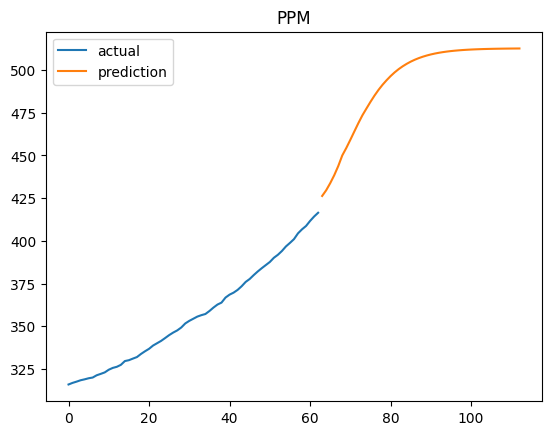

In [281]:
plt.plot(unnormalize(data_normed, data.min(axis=0), data.max(axis=0)),
         label='actual')  # our val was taken as subset of the normaized data so we need to unnormalize it here
# plt.plot(unnormalize(pred[0][0], data.min(axis=0), data.max(axis=0)), label='prediction')

plt.plot(plt_x, plt_y, label = 'prediction')

plt.legend()
plt.title('PPM')
plt.show()

In [282]:
preds = model.predict(windowed_dataset(data_normed, batch_size, n_past, n_future, shift))
preds[0]

2/2 [==============================] - 1s 24ms/step


array([0.06704473, 0.08508381, 0.09657023, 0.09614456, 0.11299863],
      dtype=float32)

In [283]:
unnormalize(pred, data.min(axis=0), data.max(axis=0))

array([[512.56763359, 518.92752968, 544.64600944, 554.35987277,
        534.99830683]])

In [284]:
preds_unnormed = unnormalize(preds, data.min(axis=0), data.max(axis=0))

In [285]:
print(preds_unnormed.shape)
print(preds_unnormed[:, 0])
print(preds_unnormed[:, 0].shape)

(54, 5)
[322.71598452 323.35716644 323.9203589  324.49537113 325.06760021
 325.72284307 326.49387168 327.46145413 328.35089442 329.31302586
 330.41497031 331.4116403  332.43181956 333.59024284 334.78938479
 335.71670521 336.90964758 338.30510534 339.9297781  341.48865844
 343.05941544 344.70100415 346.24318113 347.84677894 349.52938275
 351.25116319 352.9884957  354.79737856 356.72911207 358.55954447
 359.94673662 361.21473111 362.52401016 363.93046126 365.59005434
 367.71457494 369.91992802 372.05127549 374.17499962 376.56395347
 378.56278189 380.64792824 383.08498155 385.73221848 388.37302379
 390.81149038 393.3433473  395.77589128 398.15253282 400.56488964
 403.12258086 405.83624798 408.44873977 411.34188759]
(54,)
